<a href="https://colab.research.google.com/github/Khawaritzmi/Deep-Learning/blob/master/COVID_Ensemble_ResNeXt50_InceptionResnetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans/"

/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans


%cd "/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans"

In [0]:
#%tensorflow_version 1.x

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import numpy as np
import pickle
import cv2
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_applications.resnext import ResNeXt50
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Average, GlobalMaxPool2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from typing import Tuple, List

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()

Using TensorFlow backend.


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((224, 224))
image_size = 0
directory_root = "/content/drive/My Drive/COVID-19CT/covidct/"
width=224
height=224
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True:
                #if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing CT_NonCOVID ...
[INFO] Processing CT_COVID ...
[INFO] Image loading completed
CPU times: user 851 µs, sys: 0 ns, total: 851 µs
Wall time: 735 µs


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
label=[]
for i in image_labels:
  if i == [0]:
    label.append([1,0])
  else:
    label.append([0,1])

labels = np.array(label)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size=0.2, random_state = 42)

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
def resNext_model(width_r, height_r ,depth_r,n_classes_r ):
    base_model = ResNeXt50(input_tensor=Input(shape = (width_r, height_r, depth_r)), include_top = False, weights = None, 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(n_classes_r, activation= 'softmax')(x)

    model = Model(inputs = base_model.input, outputs = x)
    return model

In [0]:
def InceptionResnet_model(width_i, height_i ,depth_i,n_classes_i ):
    base_model = InceptionResNetV2(weights= None, include_top=False, input_tensor=Input(shape = (width_i, height_i, depth_i)))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(n_classes_i, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = x)
    return model

In [0]:
model1 = resNext_model(width, height, depth, n_classes)
model2 = InceptionResnet_model(width, height, depth, n_classes)

In [0]:
from keras.layers import Flatten, Input, concatenate
combinedInput = concatenate([model1.output, model2.output])

In [0]:
# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
#x = Dense(1024, activation="relu")(combinedInput)
x = Dense(n_classes, activation="softmax")(combinedInput)

In [20]:
# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
final_model = Model(inputs=[model2.input, model1.input], outputs=x)
print(final_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [21]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
final_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [22]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.config.experimental.set_memory_growth

<function tensorflow.python.framework.config.set_memory_growth>

In [23]:
%%time
history = final_model.fit_generator(aug.flow([x_train, x_train], y_train, batch_size=BS),
                                    epochs = EPOCHS, steps_per_epoch=x_train.shape[0] // BS,
                                    validation_data = ([x_test,x_test], y_test), 
                                    callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
                                    verbose=2)

Epoch 1/100
 - 135s - loss: 2.1339 - accuracy: 0.5562 - val_loss: 6.9017 - val_accuracy: 0.5500
Epoch 2/100
 - 21s - loss: 0.6503 - accuracy: 0.6969 - val_loss: 7.2480 - val_accuracy: 0.4500
Epoch 3/100
 - 21s - loss: 0.7540 - accuracy: 0.6719 - val_loss: 6.0208 - val_accuracy: 0.5500
Epoch 4/100
 - 21s - loss: 0.6301 - accuracy: 0.7406 - val_loss: 0.7745 - val_accuracy: 0.4500
Epoch 5/100
 - 21s - loss: 0.4550 - accuracy: 0.7719 - val_loss: 0.8185 - val_accuracy: 0.4500
Epoch 6/100
 - 21s - loss: 0.4316 - accuracy: 0.8250 - val_loss: 0.9016 - val_accuracy: 0.4500
Epoch 7/100
 - 21s - loss: 0.3638 - accuracy: 0.8250 - val_loss: 1.3067 - val_accuracy: 0.4500
Epoch 8/100
 - 21s - loss: 0.3578 - accuracy: 0.8781 - val_loss: 1.2660 - val_accuracy: 0.4500
Epoch 9/100
 - 21s - loss: 0.3386 - accuracy: 0.8562 - val_loss: 0.9787 - val_accuracy: 0.4500
Epoch 10/100
 - 21s - loss: 0.2932 - accuracy: 0.9125 - val_loss: 1.3844 - val_accuracy: 0.4500
Epoch 11/100
 - 21s - loss: 0.3027 - accuracy: 0

In [24]:
scores = final_model.evaluate([x_test,x_test], y_test)
print(f"Test Accuracy: {scores[1]*100}")

80/80 [==============================] - 2s 21ms/step
Test Accuracy: 76.2499988079071


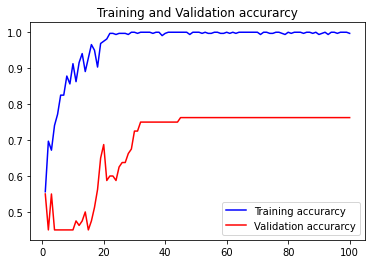

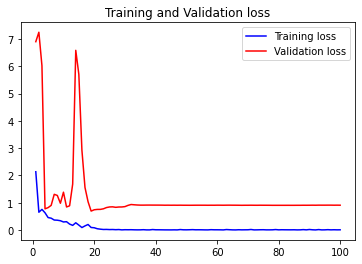

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()